# Exercise project 3 (CNN time-series classification)
### **Step 0:** Importing necessary libraries

In [42]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

### **Step 1**: Reading the dataset

In [43]:
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Let's check if the dataset has any null values and use describe to have an overview of the numerical columns.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2691 entries, 0 to 2690
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2691 non-null   object 
 1   Open       2691 non-null   float64
 2   High       2691 non-null   float64
 3   Low        2691 non-null   float64
 4   Close      2691 non-null   float64
 5   Adj Close  2691 non-null   float64
 6   Volume     2691 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 147.3+ KB


In [45]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2.691000e+03
mean,11067.257301,11365.906054,10735.769010,11078.838895,11078.838895,1.464449e+10
std,15942.260540,16372.505178,15442.789057,15944.078311,15944.078311,2.008151e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,603.274506,607.488006,598.279511,605.210510,605.210510,7.854280e+07
50%,6253.549805,6388.629883,6119.680176,6274.580078,6274.580078,5.014430e+09
75%,10346.236817,10572.645996,10111.598144,10347.236817,10347.236817,2.457629e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


### **Step 2:** Data cleanup, sequencing and scaling

For this excercise, I will use the *Close* and *Volume* columns as the 2 classes.

In [46]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)

I scale the numeric columns using *scikit-learn*'s *MinMaxScaler()*

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

num_cols = ['Close', 'Volume']
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,Date,Close,Volume
0,2014-09-17,0.004144,0.000043
1,2014-09-18,0.003655,0.000081
2,2014-09-19,0.003216,0.000091
3,2014-09-20,0.003425,0.000088
4,2014-09-21,0.003275,0.000059


The Date column should be converted to a sequence column, so that the model can understand it.

In [48]:
df['Sequence'] = df.index + 1
df = df.drop(['Date'], axis=1)
df.head()

,Close,Volume,Sequence
0,0.004144,0.000043,1
1,0.003655,0.000081,2
2,0.003216,0.000091,3
3,0.003425,0.000088,4
4,0.003275,0.000059,5


### **Step 3:** Timesteps

In [49]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 50

close = df['Close'].values
volume = df['Volume'].values

close_windows = sliding_window_view(close, window_shape=timestep_size)[::timestep_size]
volume_windows = sliding_window_view(volume, window_shape=timestep_size)[::timestep_size]

X = np.vstack((close_windows, volume_windows))

# 0 = Close
# 1 = Volume
y = np.array([0] * len(close_windows) + [1] * len(volume_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (106, 50)
y: (106,)


In [50]:
from sklearn.utils import shuffle

# shuffle the data
X, y = shuffle(X, y, random_state=42)

In [51]:
train_size = 0.75
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [52]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

79
27
79
27


In [53]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [54]:
class_names = np.array(['Close', 'Volume'])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Jupyter kernel after this
# keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,802 (18.76 KB)

 Trainable params: 4,674 (18.26 KB)

 Non-trainable params: 128 (512.00 B)

In [55]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    )
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - loss: 0.7888 - sparse_categorical_accuracy: 0.4127 - val_loss: 0.7018 - val_sparse_categorical_accuracy: 0.1875
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.7567 - sparse_categorical_accuracy: 0.4286 - val_loss: 0.6997 - val_sparse_categorical_accuracy: 0.3125
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.7035 - sparse_categorical_accuracy: 0.5873 - val_loss: 0.6977 - val_sparse_categorical_accuracy: 0.3125
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.6790 - sparse_categorical_accuracy: 0.6032 - val_loss: 0.6960 - val_sparse_categorical_accuracy: 0.3125
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.6565 - sparse_categorical_accuracy: 0.6190 - val_loss: 0.6948 - val_sparse_categorical_accuracy: 0.3125
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.6473 - sparse_categorical_accuracy: 0.6349 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.3125
Epoch 7/50

<Axes: >

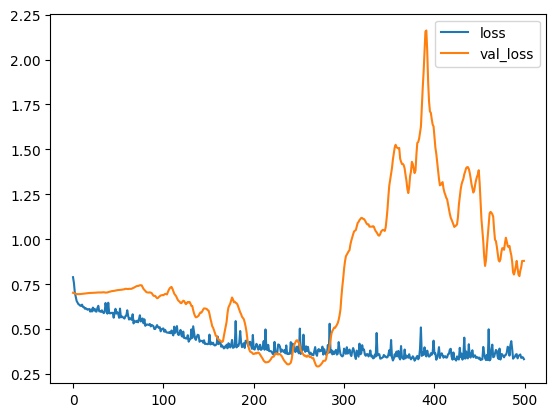

In [56]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

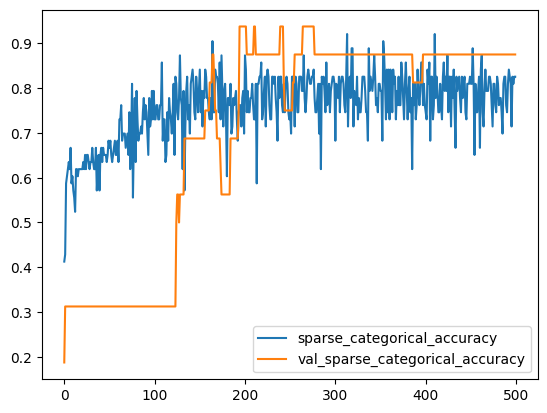

In [57]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()